In [1]:
import pandas as pd
import numpy as np
import math

ALPHA = 0.8
eps = 1e-4
data = pd.read_csv("/Users/hasan.nayir/Projects/Payten/app2scale_reinforcement_learning/server_client_v4/data.csv")

In [ ]:
# Reward v1

ALPHA = 0.8

data["utilization"] = np.minimum(data["cpu_usage"]/(data["cpu"]/10),1)
data["performance_request"] = np.minimum(round(data['num_request'] /  (data['expected_tps']),6),1)

for i in range(0, data.shape[0]):
    temp = data.iloc[i,:]
    if temp["response_time"] >= 20:
        data.loc[i, "performance_response"] = 20/temp["response_time"]
    else:
        data.loc[i, "performance_response"] = 1

data["performance"] = 0.5*data["performance_request"] + 0.5*data["performance_response"]
data["reward"] = data["performance"] * ALPHA + data["utilization"] * (1-ALPHA)


drop_rows = (data["cpu_usage"] != 0) | (data["memory_usage"] != 0)
hybrid_data = data[drop_rows].reset_index(drop=True)

In [ ]:
# A-SARSA: A Predictive Container Auto-Scaling Algorithm Based on Reinforcement Learning


ALPHA = 0.8
drop_rows = (data["cpu_usage"] != 0) | (data["memory_usage"] != 0)
hybrid_data = data[drop_rows].reset_index(drop=True)

hybrid_data["utilization"] = np.minimum(hybrid_data["cpu_usage"]/(hybrid_data["cpu"]/10),1)

for i in range(0, hybrid_data.shape[0]):
    temp = hybrid_data.iloc[i,:]
    if temp["response_time"] >= 20:
        hybrid_data.loc[i, "reward"] = np.maximum((1-math.exp(-0.5*(1-(temp["response_time"]/20))))/(1-np.minimum(temp["utilization"], 0.99)),-2)
    else:
        hybrid_data.loc[i, "reward"] = np.maximum((1-math.exp(-0.5))/(1-np.minimum(temp["utilization"], 0.99)),-2)


In [2]:
# Alternative reward function


ALPHA = 0.8
drop_rows = (data["cpu_usage"] != 0) | (data["memory_usage"] != 0)
hybrid_data = data[drop_rows].reset_index(drop=True)

hybrid_data["utilization"] = np.minimum(hybrid_data["cpu_usage"]/(hybrid_data["cpu"]/10),1)

for i in range(0, hybrid_data.shape[0]):
    temp = hybrid_data.iloc[i,:]

    hybrid_data.loc[i, "reward"] = math.tanh((20-temp["response_time"]))*temp["utilization"]


In [ ]:
# Deneme


In [3]:
import gymnasium as gym
import numpy as np
import os
import pandas as pd
import ray._private.utils
from gymnasium.spaces import Discrete, Box
from ray.rllib.models.preprocessors import get_preprocessor
from ray.rllib.evaluation.sample_batch_builder import SampleBatchBuilder
from ray.rllib.offline.json_writer import JsonWriter
from itertools import product


def convert_data_to_batch(df, writer, eps_id_list):
    number_episodes = int(df.shape[0]/episode_length)
    remained_steps = df.shape[0]-number_episodes*episode_length
    for eps_id,idx in zip(eps_id_list, range(len(eps_id_list))):
        print(eps_id)
        try:
            data = df.iloc[idx*episode_length:(idx+1)*episode_length]
        except:
            data = df.iloc[idx*episode_length:(idx+1)*remained_steps]

        first_row = data.iloc[0,:]
        obs = np.array([first_row['replica'], first_row['cpu'], first_row['heap'], first_row["expected_tps"]], dtype=np.float32)
        info = {}
        possible_state_value = np.array([first_row['replica'], first_row['cpu'], first_row['heap']])
        equal_rows = np.all(POSSIBLE_STATES == possible_state_value, axis=1)
        prev_action = np.where(equal_rows)[0][0]
        prev_reward = 0
        terminated = truncated = False
        # print("aaa",data.shape[0])
        for i in range(0, data.shape[0]):
            truncated = True if i == data.shape[0]-1 else False
            terminated = truncated
            selected_row = data.iloc[i,:]
            possible_state_value = np.array([selected_row['replica'], selected_row['cpu'], selected_row['heap']])
            equal_rows = np.all(POSSIBLE_STATES == possible_state_value, axis=1)
            action = np.where(equal_rows)[0][0]
            new_obs = np.array([selected_row['replica'], selected_row['cpu'], selected_row['heap'], selected_row["expected_tps"]], dtype=np.float32)
            rew = selected_row["reward"]
            # obs = obs
            # new_obs = new_obs

            batch_builder.add_values(
                t=i,
                eps_id=eps_id,
                agent_index=0,
                # obs=prep.transform(obs),
                obs = obs,
                actions=action,
                action_prob=1.0, 
                action_logp=0.0,
                rewards=rew,
                prev_actions=prev_action,
                prev_rewards=prev_reward,
                terminateds=terminated,
                truncateds=truncated,
                infos=info,
                # new_obs=prep.transform(new_obs),
                new_obs = new_obs,

            )
            obs = new_obs
            prev_action = action
            prev_reward = rew
        writer.write(batch_builder.build_and_reset())


if __name__ == "__main__":
    batch_builder = SampleBatchBuilder()
    training_writer = JsonWriter(
        os.path.join(ray._private.utils.get_user_temp_dir(), "training-out")
    )
    eval_writer = JsonWriter(
        os.path.join(ray._private.utils.get_user_temp_dir(), "eval-out")
    )
    
    action_space = Discrete(108) #6*6*6
    observation_space = Box(low=np.array([1, 4, 4, 0]), high=np.array([3, 9, 9, 1000]), dtype=np.float32)
    replica = [1, 2, 3]
    cpu = [4, 5, 6, 7, 8, 9]
    heap = [4, 5, 6, 7, 8, 9]
    POSSIBLE_STATES = np.array(list(product(replica, cpu, heap)))


    prep = get_preprocessor(observation_space)(observation_space)
    print("The preprocessor is", prep)
    episode_length = 100
    full_data = hybrid_data
    training_split_ratio = 0.8
    train_df = full_data.sample(frac=training_split_ratio, random_state=42)  # Eğitim verisi
    eval_df = full_data.drop(train_df.index) 
    train_df = train_df.reset_index(drop=True)
    eval_df = eval_df.reset_index(drop=True)

    number_episodes_training = int(train_df.shape[0]/episode_length)
    remained_steps_training = train_df.shape[0]-number_episodes_training*episode_length
    if remained_steps_training > 0:
        number_episodes_training += 1

    # episode_length_eval = eval_df.shape[0]
    number_episodes_eval= int(eval_df.shape[0]/episode_length)
    remained_steps_eval = eval_df.shape[0]-number_episodes_eval*episode_length
    if remained_steps_eval > 0:
        number_episodes_eval += 1
        
    eps_id_training = list(range(number_episodes_training))
    eps_id_eval = list(range(len(eps_id_training), number_episodes_eval+ len(eps_id_training)))
    convert_data_to_batch(train_df, training_writer, eps_id_training)
    convert_data_to_batch(eval_df, eval_writer, eps_id_eval)


/Users/hasan.nayir/miniconda3/envs/rl_lib/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-28 15:49:09,402	WARNING deprecation.py:50 -- DeprecationWarning: `SampleBatchBuilder` has been deprecated. Use `a child class of `SampleCollector`` instead. This will raise an error in the future!
/Users/hasan.nayir/miniconda3/envs/rl_lib/lib/python3.9/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


The preprocessor is <ray.rllib.models.preprocessors.NoPreprocessor object at 0x2c1cebee0>
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


/Users/hasan.nayir/miniconda3/envs/rl_lib/lib/python3.9/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Started training with lr: 0.0001 and fcnet: [32, 32]


2024-02-28 15:51:17,771	WARNING json_reader.py:261 -- Treating input directory as glob patterns: ['/tmp/training-out/*.json', '/tmp/training-out/*.zip']
2024-02-28 15:51:17,789	WARNING json_reader.py:261 -- Treating input directory as glob patterns: ['/tmp/eval-out/*.json', '/tmp/eval-out/*.zip']
Install gputil for GPU system monitoring.


------------- Iteration 1 -------------
timesteps_total: 1200
training_iteration_time_ms: 60.021
------------- Iteration 2 -------------
timesteps_total: 2402
training_iteration_time_ms: 64.648
== Evaluation ==
{'is': {'v_behavior': -18.88612183036573, 'v_behavior_std': 6.283915006441462, 'v_target': -0.003977489717029744, 'v_target_std': 0.0037182861680251284, 'v_gain': -397748.9717029744, 'v_delta': 18.8821443406487}, 'wis': {'v_behavior': -18.88612183036573, 'v_behavior_std': 6.283915006441462, 'v_target': -19.23219018995482, 'v_target_std': 13.001664625260863, 'v_gain': -1923219018.9954822, 'v_delta': -0.34606835958909593}}
------------- Iteration 3 -------------
timesteps_total: 3602
training_iteration_time_ms: 73.914
------------- Iteration 4 -------------
timesteps_total: 4804
training_iteration_time_ms: 68.853
== Evaluation ==
{'is': {'v_behavior': -18.603389406815584, 'v_behavior_std': 6.43891259024533, 'v_target': -0.004122817751790982, 'v_target_std': 0.003773614149807826, '

/Users/hasan.nayir/miniconda3/envs/rl_lib/lib/python3.9/site-packages/ray/rllib/offline/estimators/weighted_importance_sampling.py:63: RuntimeWarning: invalid value encountered in scalar divide
  v_target += episode_p[t] / w_t * rewards[t] * self.gamma**t


timesteps_total: 11994612
training_iteration_time_ms: 87.219
== Evaluation ==
{'is': {'v_behavior': -18.603389406815584, 'v_behavior_std': 6.43891259024533, 'v_target': 0.028158406110902406, 'v_target_std': 0.04690104014165936, 'v_gain': 2815840.6110902405, 'v_delta': 18.63154781292648}, 'wis': {'v_behavior': -18.603389406815584, 'v_behavior_std': 6.43891259024533, 'v_target': nan, 'v_target_std': nan, 'v_gain': nan, 'v_delta': nan}}
------------- Iteration 9987 -------------
timesteps_total: 11995812
training_iteration_time_ms: 84.735
------------- Iteration 9988 -------------
timesteps_total: 11997014
training_iteration_time_ms: 87.571
== Evaluation ==
{'is': {'v_behavior': -18.603389406815584, 'v_behavior_std': 6.43891259024533, 'v_target': 0.028834407410354063, 'v_target_std': 0.04798142706262047, 'v_gain': 2883440.7410354065, 'v_delta': 18.632223814225934}, 'wis': {'v_behavior': -18.603389406815584, 'v_behavior_std': 6.43891259024533, 'v_target': nan, 'v_target_std': nan, 'v_gain'

FileNotFoundError: [Errno 2] No such file or directory: './server_client_v2_offline/results/DQN_None_2024-02-28_15-51-17uhdqrpzl_lr_0.0001_fcnet_32_32.pdf'

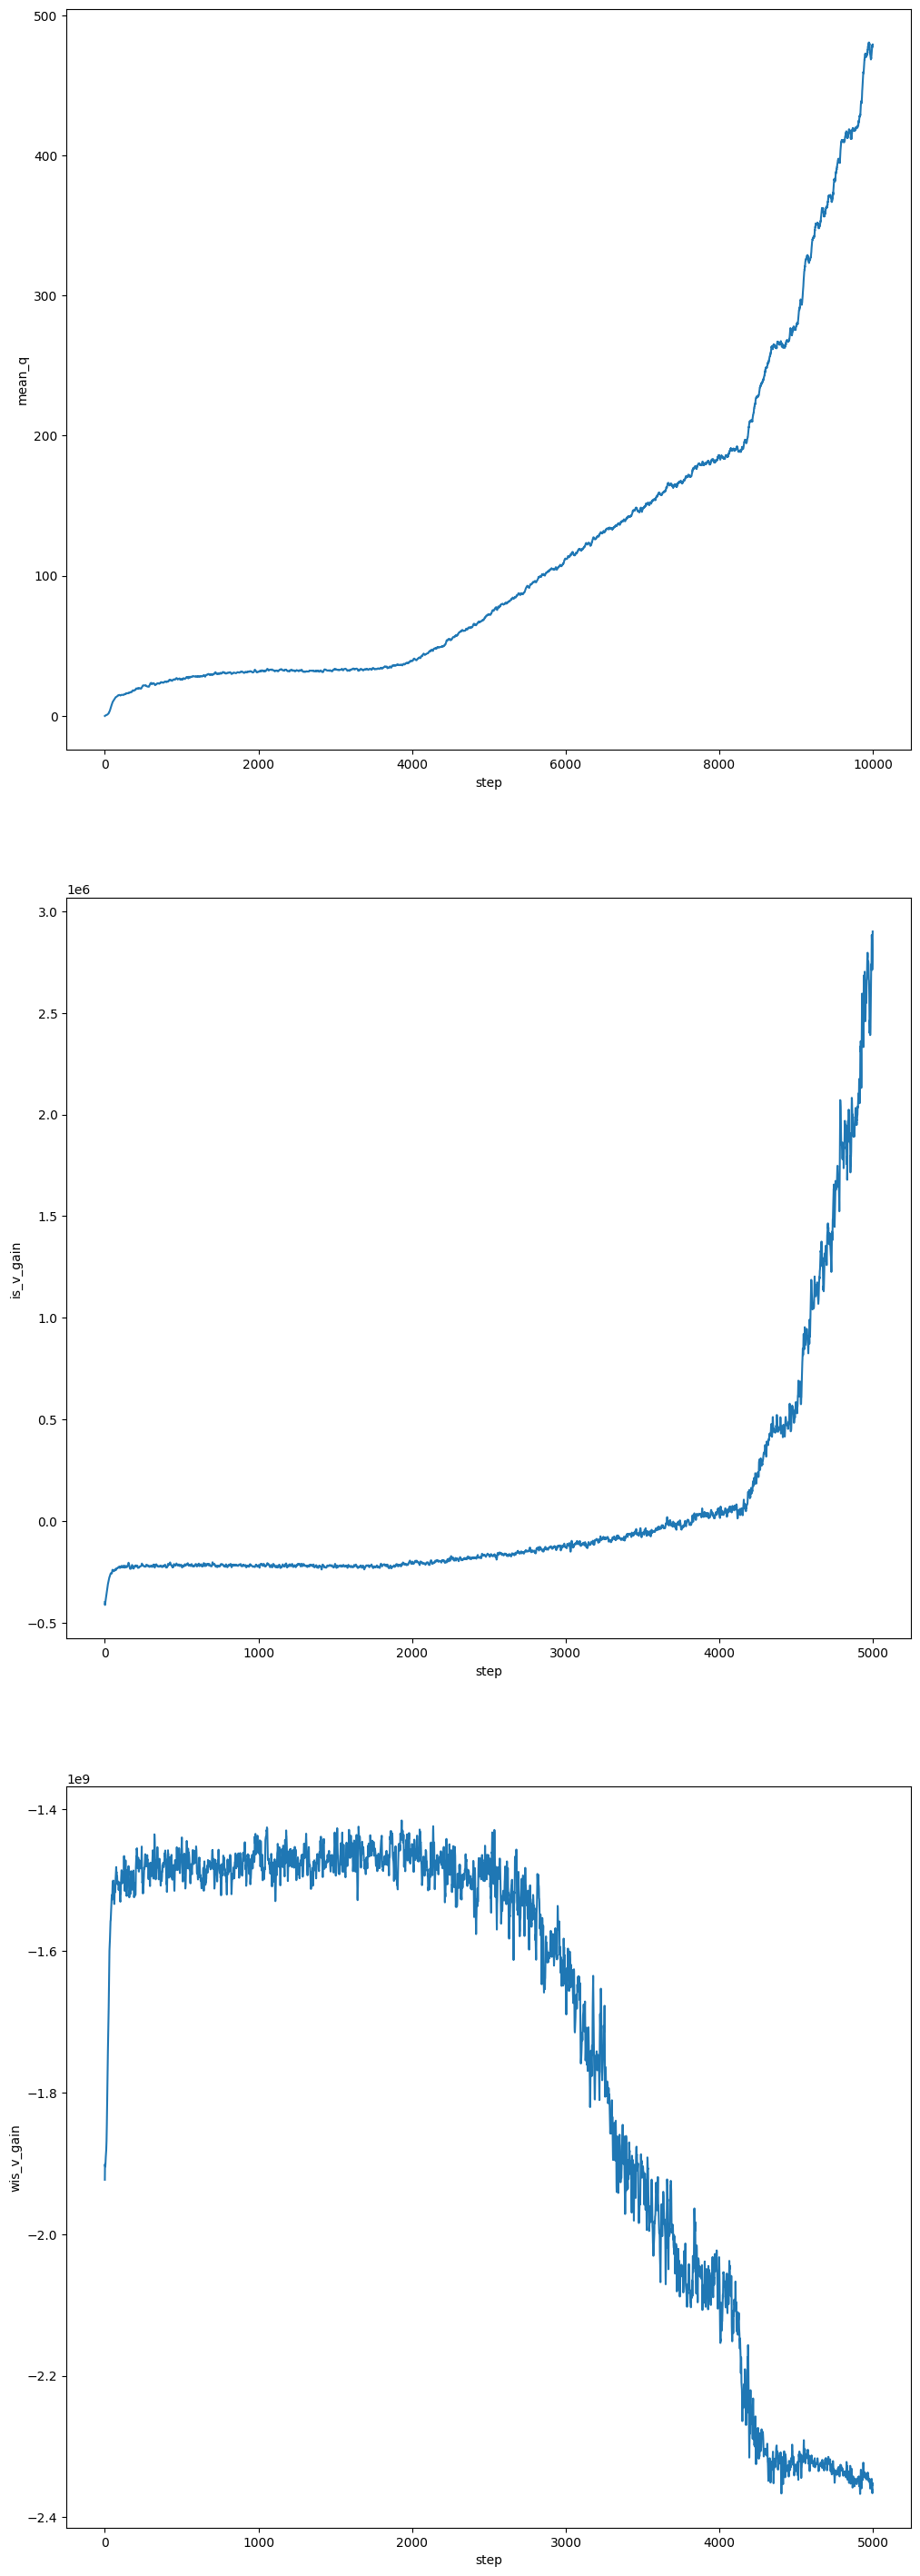

In [4]:
from ray.rllib.algorithms.dqn import DQNConfig
from ray.rllib.offline.estimators import ImportanceSampling
from ray.rllib.offline.estimators.fqe_torch_model import FQETorchModel
from gymnasium.spaces import Discrete, Box
import numpy as np
from ray.rllib.offline.estimators import ImportanceSampling, WeightedImportanceSampling
from itertools import product
import matplotlib.pyplot as plt
import inspect


def generate_config(train_path, eval_path, hyper_params):
    learning_rate = hyper_params[0]
    fcnet_hiddens = hyper_params[1]
    config = (
        DQNConfig()
        .environment(env=None,
                    action_space=Discrete(108), 
                    observation_space=Box(low=np.array([1, 4, 4, 0]), high=np.array([3, 9, 9, 1000]), dtype=np.float32)
                    )
        .training(model={"fcnet_hiddens": fcnet_hiddens},
                  gamma=0.99,
                  lr=learning_rate,
                  train_batch_size=256
        )
                
        .offline_data(input_=train_path)
        .exploration(explore=False)
        .evaluation(evaluation_parallel_to_training=False,
                    evaluation_interval=2,
                    evaluation_duration=10,
                    evaluation_duration_unit="episodes",
                    evaluation_config={"input": eval_path},
                    off_policy_estimation_methods={"is": {"type": ImportanceSampling},
                                                   "wis": {"type": WeightedImportanceSampling}
                    }
        )
                    

    )
    return config



def generate_plots(filename,  mean_q_list, is_v_gain_list,wis_v_gain_list):
    fig, ax = plt.subplots(nrows=len(inspect.signature(generate_plots).parameters)-1,ncols=1,figsize=(12,36))
    ax[0].plot(mean_q_list)
    ax[0].set_xlabel('step')
    ax[0].set_ylabel('mean_q')
    ax[1].plot(is_v_gain_list)
    ax[1].set_xlabel('step')
    ax[1].set_ylabel('is_v_gain')
    ax[2].plot(wis_v_gain_list)
    ax[2].set_xlabel('step')
    ax[2].set_ylabel('wis_v_gain')
    plt.savefig(filename)


hyperparameters = {"learning_rate": [1e-04],
                   "fcnet_hiddens": [[32,32]]
                   }
parameter_combinations = list(product(*hyperparameters.values())) # This variable includes all combinations of the hyperparameters. ex. (1e-05, [32, 32])


train_path = "/tmp/training-out"
eval_path = "/tmp/eval-out"
epoch_number = 10000

for comb in parameter_combinations:
    config = generate_config(train_path, eval_path, comb)
    print(f"Started training with lr: {comb[0]} and fcnet: {comb[1]}")
    mean_q_list = []
    is_v_gain_list = []
    wis_v_gain_list = []

    # config['observation_filter'] = "MeanStdFilter"
    algo = config.build()
    debug_dir = "{}checkpoints/".format(algo.logdir)
    filename = f"./server_client_v2_offline/results/{algo.logdir.split('/')[-2]}_lr_{comb[0]}_fcnet_{comb[1][0]}_{comb[1][1]}.pdf"
    for i in range(epoch_number):
        print("------------- Iteration", i+1, "-------------")
        results = algo.train()
        print("timesteps_total:", results['timesteps_total'])
        print("training_iteration_time_ms:", results['timers']['training_iteration_time_ms'])
        if 'evaluation' in results.keys():
            print("== Evaluation ==")
            if 'off_policy_estimator' in results['evaluation'].keys():
                print(results['evaluation']['off_policy_estimator'])
                is_v_gain_list.append(results['evaluation']['off_policy_estimator']["is"]["v_gain"])
                wis_v_gain_list.append(results['evaluation']['off_policy_estimator']["wis"]["v_gain"])


        if (i+1) % 5000 == 0:
            ma_checkpoint_dir = algo.save(checkpoint_dir=debug_dir)
            print(
                "An Algorithm checkpoint has been created inside directory: "
                f"'{ma_checkpoint_dir}'"
            )
        mean_q_list.append(results["info"]["learner"]["default_policy"]["learner_stats"]["mean_q"])

    algo.stop()
    generate_plots(filename, mean_q_list,is_v_gain_list,wis_v_gain_list)


In [2]:
# Testing

from gevent import monkey
monkey.patch_all(thread=False, select=False)
from locust.env import Environment
from kubernetes import client, config

from prometheus_api_client import PrometheusConnect

from ray.rllib.env.policy_client import PolicyClient
import pandas as pd
import time
import numpy as np
from collections import OrderedDict
from gymnasium.spaces import Discrete, Dict, MultiDiscrete, Tuple, Box
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

import ssl
import random
import logging
import ray
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.env.policy_server_input import PolicyServerInput
from locust import HttpUser, task, constant, constant_throughput, events
from locust.shape import LoadTestShape

ssl._create_default_https_context = ssl._create_unverified_context
from itertools import product
import time


DEPLOYMENT_NAME = "teastore-webui"
NAMESPACE = "app2scale-test"

OBSERVATION_SPACE =Box(low=np.array([1, 4, 4, 0]), high=np.array([3, 9, 9, 1000]), dtype=np.float32)

"""
    # replica : 1,2,3,4,5,6 -> 0,1,2,3,4,5 + 1
    # cpu : 4,5,6,7,8,9 -> 0,1,2,3,4,5   +   4
    # heap : 4,5,6,7,8,9 -> 0,1,2,3,4,5   +   4
"""

ACTION_SPACE = Discrete(108) # index of the possible states
replica = [1, 2, 3]
cpu = [4, 5, 6, 7, 8, 9]
heap = [4, 5, 6, 7, 8, 9]

config_dqn = (DQNConfig()
          .environment(
              env=None,
              action_space=ACTION_SPACE,
              observation_space=OBSERVATION_SPACE)

          .training(model={"fcnet_hiddens": [32,32]},
              gamma=0.99,
              lr=1e-04,
              train_batch_size=256)

          .debugging(log_level="INFO")
          .evaluation(off_policy_estimation_methods={})
          
          )


config_dqn.rl_module(_enable_rl_module_api=False)
config_dqn.training(_enable_learner_api=False)
algo = config_dqn.build() 


path_to_checkpoint = "/Users/hasan.nayir/ray_results/DQN_None_2024-02-28_15-51-17uhdqrpzl/checkpoints/checkpoint_010000"
algo.restore(path_to_checkpoint)

2024-02-28 17:00:04,047	INFO policy.py:1285 -- Policy (worker=local) running on CPU.
2024-02-28 17:00:04,049	INFO torch_policy.py:184 -- Found 0 visible cuda devices.
2024-02-28 17:00:04,062	INFO util.py:118 -- Using connectors:
2024-02-28 17:00:04,063	INFO util.py:119 --     AgentConnectorPipeline
        ObsPreprocessorConnector
        StateBufferConnector
        ViewRequirementAgentConnector
2024-02-28 17:00:04,069	INFO util.py:120 --     ActionConnectorPipeline
        ConvertToNumpyConnector
        NormalizeActionsConnector
        ImmutableActionsConnector
2024-02-28 17:00:04,071	INFO rollout_worker.py:2000 -- Built policy map: <PolicyMap lru-caching-capacity=100 policy-IDs=['default_policy']>
2024-02-28 17:00:04,072	INFO rollout_worker.py:2001 -- Built preprocessor map: {'default_policy': None}
2024-02-28 17:00:04,074	INFO rollout_worker.py:761 -- Built filter map: defaultdict(<class 'ray.rllib.utils.filter.NoFilter'>, {})
Install gputil for GPU system monitoring.
2024-02-28 

In [3]:
OBSERVATION_SPACE.sample()

array([  1.5175079,   7.7169633,   5.693394 , 747.1528   ], dtype=float32)

obs = np.array([first_row['replica'], first_row['cpu'], first_row['heap'], first_row["cpu_usage"],first_row["memory_usage"],first_row["response_time"], first_row["expected_tps"]], dtype=np.float32)


In [14]:
ACTION_SPACE = Discrete(108) # index of the possible states
replica = [1, 2, 3]
cpu = [4, 5, 6, 7, 8, 9]
heap = [4, 5, 6, 7, 8, 9]

POSSIBLE_STATES = np.array(list(product(replica, cpu, heap)))

obs = np.array([  1,  2,  9 , 24   ], dtype=np.float32)
test_step = 500
for i in range(24,test_step,8):
    
    action = algo.compute_single_action(obs)
    obs = np.concatenate([POSSIBLE_STATES[action],[i]])
    # print(action)
    print(f"Action: {POSSIBLE_STATES[action]} , Expected tps: {i}")


Action: [3 9 7] , Expected tps: 24
Action: [3 9 7] , Expected tps: 32
Action: [3 9 7] , Expected tps: 40
Action: [3 9 7] , Expected tps: 48
Action: [3 9 7] , Expected tps: 56
Action: [3 9 7] , Expected tps: 64
Action: [3 9 7] , Expected tps: 72
Action: [3 9 7] , Expected tps: 80
Action: [3 9 7] , Expected tps: 88
Action: [3 9 7] , Expected tps: 96
Action: [3 9 7] , Expected tps: 104
Action: [3 9 7] , Expected tps: 112
Action: [3 9 7] , Expected tps: 120
Action: [3 9 7] , Expected tps: 128
Action: [3 9 7] , Expected tps: 136
Action: [3 9 7] , Expected tps: 144
Action: [3 9 7] , Expected tps: 152
Action: [3 9 7] , Expected tps: 160
Action: [3 9 7] , Expected tps: 168
Action: [3 9 7] , Expected tps: 176
Action: [3 9 7] , Expected tps: 184
Action: [3 9 7] , Expected tps: 192
Action: [3 9 7] , Expected tps: 200
Action: [3 9 7] , Expected tps: 208
Action: [3 9 7] , Expected tps: 216
Action: [3 9 7] , Expected tps: 224
Action: [3 9 7] , Expected tps: 232
Action: [3 9 7] , Expected tps: 240
Ac